In [1]:
import sounddevice as sd


from source.processing import *
from config.settings import PROCESSING

from source.training import get_model
from config.settings import MODEL

from utils.plotting import plot_spectrogram

2022-05-15 16:10:03.026765: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-15 16:10:03.026790: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
freq = fft_frequencies(sr=PROCESSING.sampling_rate, n_fft=PROCESSING.n_fft)
log_freq = log_scale_freq(freq, log_base=PROCESSING.log_base, num_samples=PROCESSING.num_samples)[0]

In [3]:
x_train, y_train, x_test, y_test, scalars = load_split_tensors(PROCESSING.tensors_folder)

In [4]:
x_train.shape

(24, 512, 256, 2)

In [5]:
AE, E, D = get_model()

2022-05-15 16:10:07.370155: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-15 16:10:07.370180: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-15 16:10:07.370194: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LT35): /proc/driver/nvidia/version does not exist
2022-05-15 16:10:07.370410: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 512, 256, 2)]     0         
                                                                 
 Encoder (Sequential)        (None, 256)               33942816  
                                                                 
 Decoder (Sequential)        (None, 512, 256, 2)       4453922   
                                                                 
Total params: 38,396,738
Trainable params: 38,396,738
Non-trainable params: 0
_________________________________________________________________
None


In [113]:
AE.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=200, verbose=1)

Epoch 1/200
3/3 [==============================] - 2s 708ms/step - loss: 0.0121 - val_loss: 0.0644
Epoch 2/200
3/3 [==============================] - 2s 688ms/step - loss: 0.0122 - val_loss: 0.0643
Epoch 3/200
3/3 [==============================] - 2s 700ms/step - loss: 0.0122 - val_loss: 0.0645
Epoch 4/200
3/3 [==============================] - 2s 700ms/step - loss: 0.0123 - val_loss: 0.0638
Epoch 5/200
3/3 [==============================] - 2s 700ms/step - loss: 0.0122 - val_loss: 0.0645
Epoch 6/200
3/3 [==============================] - 2s 683ms/step - loss: 0.0123 - val_loss: 0.0642
Epoch 7/200
3/3 [==============================] - 2s 692ms/step - loss: 0.0122 - val_loss: 0.0637
Epoch 8/200
3/3 [==============================] - 2s 684ms/step - loss: 0.0121 - val_loss: 0.0641
Epoch 9/200
3/3 [==============================] - 2s 682ms/step - loss: 0.0121 - val_loss: 0.0640
Epoch 10/200
3/3 [==============================] - 2s 703ms/step - loss: 0.0121 - val_loss: 0.0644
Epoch 11/

In [102]:
batch = AE.predict(x_train)

In [103]:
batch.shape

(24, 512, 256, 2)

In [104]:
restored_tensor = batch_to_tensor(batch)

In [105]:
restored_sg = tensor_to_spectrogram(restored_tensor, scalars['y'])

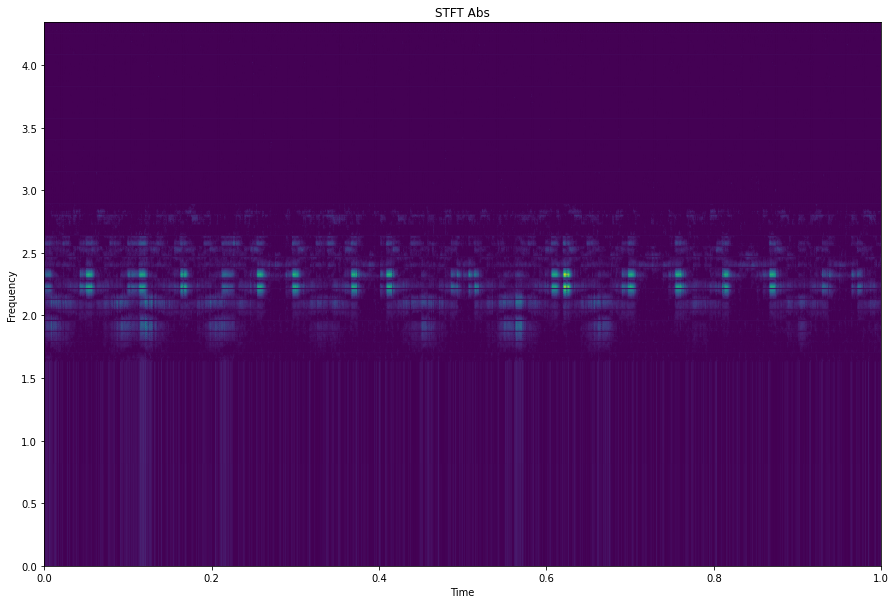

In [106]:
plot_spectrogram(log_freq, restored_sg, mode='Abs')

In [107]:
rescaled_restored_sg = inverse_log_scale(log_freq, restored_sg)

In [108]:
restored_audio = spectrogram_to_wav(rescaled_restored_sg, PROCESSING.sampling_rate)(win_length=PROCESSING.win_length, n_fft=PROCESSING.n_fft)

In [111]:
sd.play(*restored_audio)

In [112]:
sd.stop()